# Summary

1. $\alpha$ = learning rate (0 < $\alpha$ < 1)
2. $\beta$ = inverse temperature (0 < $\beta$ < 10)
3. $w$ = model-based vs. model-free (0 < $w$ < 1)
4. $\gamma$ = decay rate (0 < $\gamma$ < 1)

Parameter | n stages | 1. Baseline | 2. Counterfactual | 3. More trials | 4. Both
:---------|:--------:|-------------|-------------------|----------------|-----------:
**$\alpha$** |   2    | 0.32   |  0.39 | 0.43 | **0.48**
 |   3    | 0.11   | 0.09 | 0.2 | **0.21**
 |   4    | 0.06   | 0.05 | **0.16** | 0.15
 |   5    | 0.05   | 0.03 | **0.15** | 0.13
**$\beta$** |   2    | 0.55   | 0.58 | **0.68** | 0.66
 |   3    | 0.23   | 0.21 | **0.26** | 0.22
 |   4    | 0.19   | 0.14 | **0.25** | 0.17
 |   5    | 0.2   | 0.15 | **0.25** | 0.16
**$w$** |   2    | 0.38   | 0.36 | **0.53** | 0.52
 |   3    | 0.19   | 0.21 | 0.28 | **0.33**
 |   4    | 0.11   | 0.15 | **0.23** | **0.23**
 |   5    | 0.1   | 0.14 | **0.18** | 0.15
**$\gamma$** |   2    | 0.32   | 0.12 | **0.47** | 0.17
 |   3    | 0.27   | 0.14 | **0.35** | 0.26
 |   4    | 0.15   | 0.16 | **0.44** | 0.35
 |   5    | 0.15   | 0.12 | **0.43** | 0.37
 
 * Thoughts:
1. Overall, having more trials alone yields the best parameter recovery performance. Adding counterfactual doesn’t seem to improve recovery performance.
2. It turns out that low recovery of n-states cannot be solely attributed to less number of trials per state-action pair, as the results of 3 tells us. There might be a unique effect of having multiple second-states after all.
3. It’s weird that for gamma, adding counterfactual worsens the parameter recovery performance. Could it be because the counterfactual options weren't discounted in my simulation (i.e., the option not selected weren't multiplied by gamma, like other unselected choices)?
4. Actually, the recovery performance of 2-states is not that good to start with: baseline results for 2-states are beta 0.55, alpha 0.32, w 0.38, gamma 0.32. 
5. Could it be because we didn’t include beta_c parameter (as in your 2017 paper)?
6. Could it be because the reward ratio between common vs. rare transition was 60:40? -> re-ran the same procedures again with 0.75:0.25 ratio instead of 0.6:0.4, but didn't improve, so no
7. When observing the plots, there’s a tendency that w is “over-recovered” as the number of second-stage steps increase, leading to lower correlation coefficient. This looks more pronounced in 3 (only increasing the number of trials)
8. For model fitting, do Bayesian instead of MLE?
9. Maybe some parameters are correlated with each other? -> check off-diagonals of the inverse Hessian? If so, think of ways for reparameterization?
10. Taking all these together, if we were to do behavioral experiments, we should seek the optimal balance between number of trials and experiment time
11. One solution to reconcile with number of trials: instead of 5C2, do pseudorandom pairs (e.g., in the case of RLDDM paper, instead of using all 6 combination pairs, use AB, AC, BD, CD?)

 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import io
import os
import re

In [ ]:
# relevant_path = %pwd
# included_extensions=['.mat']
# included_structs = ['CI_table', 'corrtable']
# file_names = [fn for fn in os.listdir(relevant_path)
#               if any(fn.endswith(ext) for ext in included_extensions)]
# file_names = ['recovery_results_2states_4params_nrits1000.mat', 
#              'recovery_results_3states_4params_nrits1000.mat', 
#              'recovery_results_4states_4params_nrits1000.mat', 
#              'recovery_results_5states_4params_nrits1000.mat']



# 1. 1 alpha, 200 trials

The correlation coefficient for alpha 2 stages: 0.45
The correlation coefficient for alpha 3 stages: 0.15
The correlation coefficient for alpha 4 stages: 0.08
The correlation coefficient for alpha 5 stages: 0.06
The correlation coefficient for beta 2 stages: 0.62
The correlation coefficient for beta 3 stages: 0.28
The correlation coefficient for beta 4 stages: 0.17
The correlation coefficient for beta 5 stages: 0.19
The correlation coefficient for w 2 stages: 0.49
The correlation coefficient for w 3 stages: 0.31
The correlation coefficient for w 4 stages: 0.21
The correlation coefficient for w 5 stages: 0.12
The correlation coefficient for gamma 2 stages: 0.28
The correlation coefficient for gamma 3 stages: 0.26
The correlation coefficient for gamma 4 stages: 0.22
The correlation coefficient for gamma 5 stages: 0.21


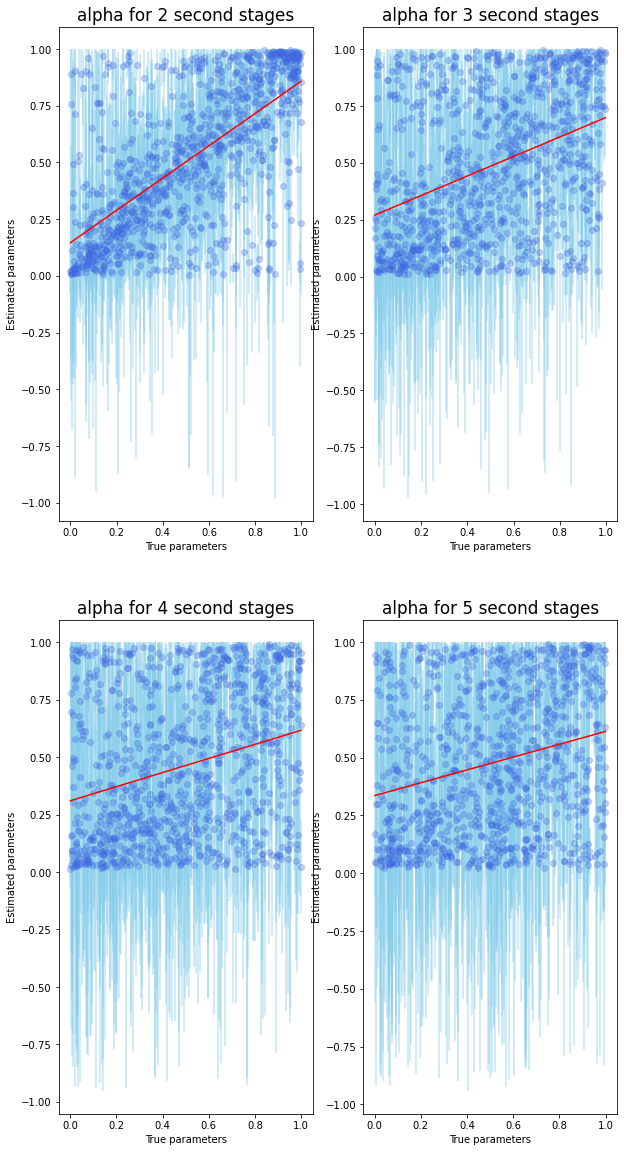

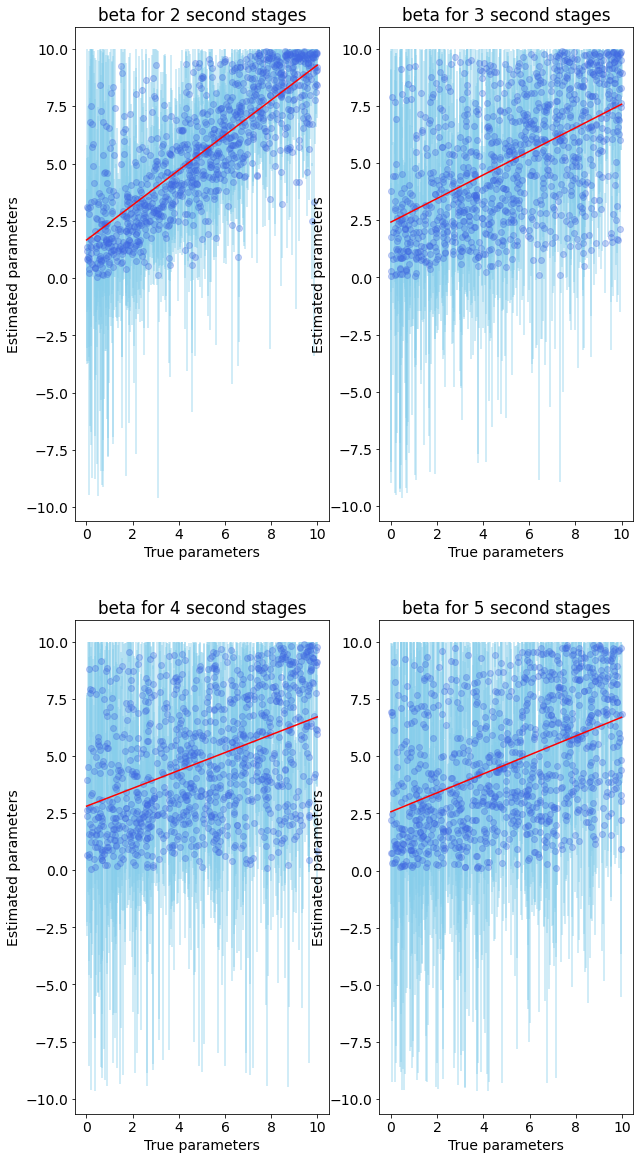

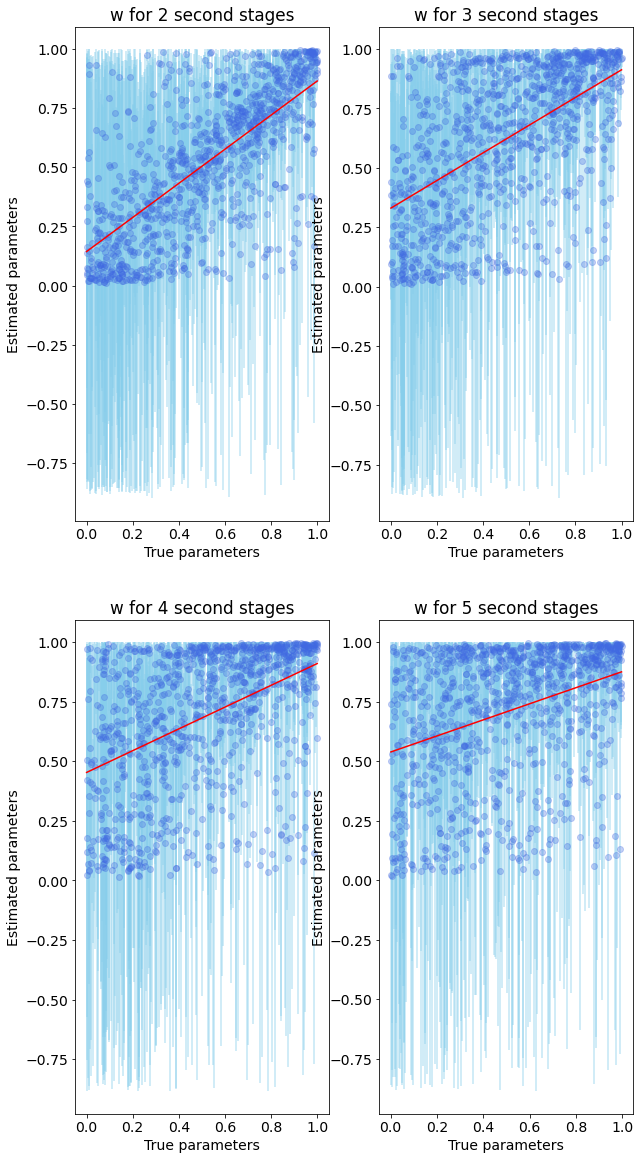

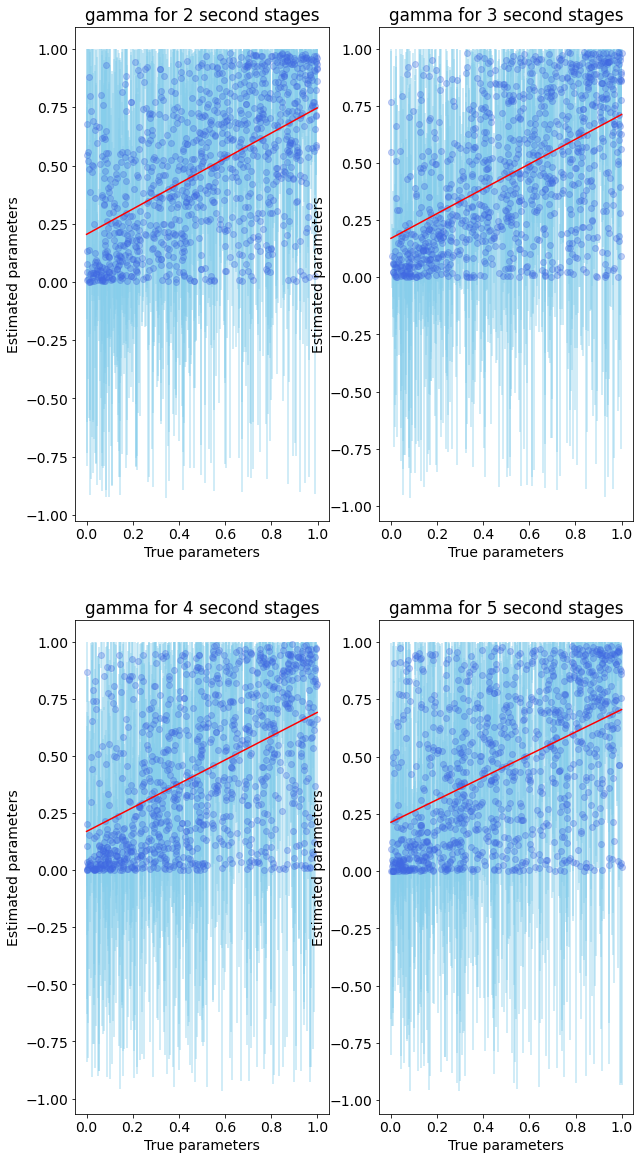

In [2]:
second_stages = [2,3,4,5]
parameters = ['alpha', 'beta', 'w', 'gamma']

for i, parameter in enumerate(parameters):
    fig, axs = plt.subplots(2,2, figsize=(10,20), facecolor='w', edgecolor='k')
#     for second_stage in second_stages:
    for s, ax in zip(range(len(second_stages)), axs.flat):
        file = 'recovery_counterfactual_1alpha_' + str(second_stages[s]) + 'states_4params_nrits1000.mat'
#         file = 'recovery_results_' + str(second_stages[s]) + 'states_4params_nrits1000.mat'

        curr_file = io.loadmat(file)
        CI_table = curr_file['data']['CI_table']
        CI_table = np.asarray(CI_table)[0][0]
        corrtable = curr_file['data']['corrtable']
        corrtable = np.asarray(corrtable)[0][0]

        num_data = len(corrtable)

        x = corrtable[:num_data,i*2]
        y = corrtable[:num_data,i*2+1]
        ci_upper = CI_table[:num_data,i*2]
        ci_lower = CI_table[:num_data,i*2+1]

        slope, intercept = np.polyfit(x,y,1) # linear model adjustment
        y_model = np.polyval([slope, intercept], x)   # modeling...

        x_mean = np.mean(x)
        y_mean = np.mean(y)
        n = x.size                        # number of samples

        # calculating the r2
        # https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
        # Pearson's correlation coefficient
        numerator = np.sum((x - x_mean)*(y - y_mean))
        denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
        correlation_coef = numerator / denominator
        r2 = correlation_coef**2

        # mean squared error
        MSE = 1/n * np.sum( (y - y_model)**2 )

        # to plot the adjusted model
        x_line = np.linspace(np.min(x), np.max(x), 100)
        y_line = np.polyval([slope, intercept], x_line)

        ############### Ploting
        plt.rcParams.update({'font.size': 14})
#         fig = plt.figure()
#         ax = fig.add_axes([.1, .1, 1, 1])

        
    
    
        title_name = parameter + ' for ' + str(second_stages[s]) + ' second stages'
        ax.set_title(title_name)
        ax.plot(x, y, 'o', color = 'royalblue', alpha=0.3)
        ax.plot(x_line, y_line, color = 'red')
        # ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% prediction interval')
        # ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% confidence interval')

        # ax.errorbar(x,y,yerr=[y-ci_lower, ci_upper-y],linestyle='',color='skyblue', alpha=.3)
        ax.errorbar(x,y,yerr=ci_upper-y,linestyle='',color='skyblue', alpha=.5)

        ax.set_xlabel('True parameters')
        ax.set_ylabel('Estimated parameters')
        
        print("The correlation coefficient for {} {} stages: {}".format(parameter, second_stages[s], np.round(r2,2)))


# plt.subplots_adjust(wspace=1, hspace=2)

# 2. 2 alphas, 200 trial

The correlation coefficient for alpha1 2 stages: 0.36
The correlation coefficient for alpha1 3 stages: 0.16
The correlation coefficient for alpha1 4 stages: 0.17
The correlation coefficient for alpha1 5 stages: 0.11
The correlation coefficient for alpha2 2 stages: 0.11
The correlation coefficient for alpha2 3 stages: 0.05
The correlation coefficient for alpha2 4 stages: 0.11
The correlation coefficient for alpha2 5 stages: 0.12
The correlation coefficient for beta 2 stages: 0.66
The correlation coefficient for beta 3 stages: 0.28
The correlation coefficient for beta 4 stages: 0.19
The correlation coefficient for beta 5 stages: 0.18
The correlation coefficient for w 2 stages: 0.48
The correlation coefficient for w 3 stages: 0.26
The correlation coefficient for w 4 stages: 0.19
The correlation coefficient for w 5 stages: 0.12
The correlation coefficient for gamma 2 stages: 0.23
The correlation coefficient for gamma 3 stages: 0.29
The correlation coefficient for gamma 4 stages: 0.21
The c

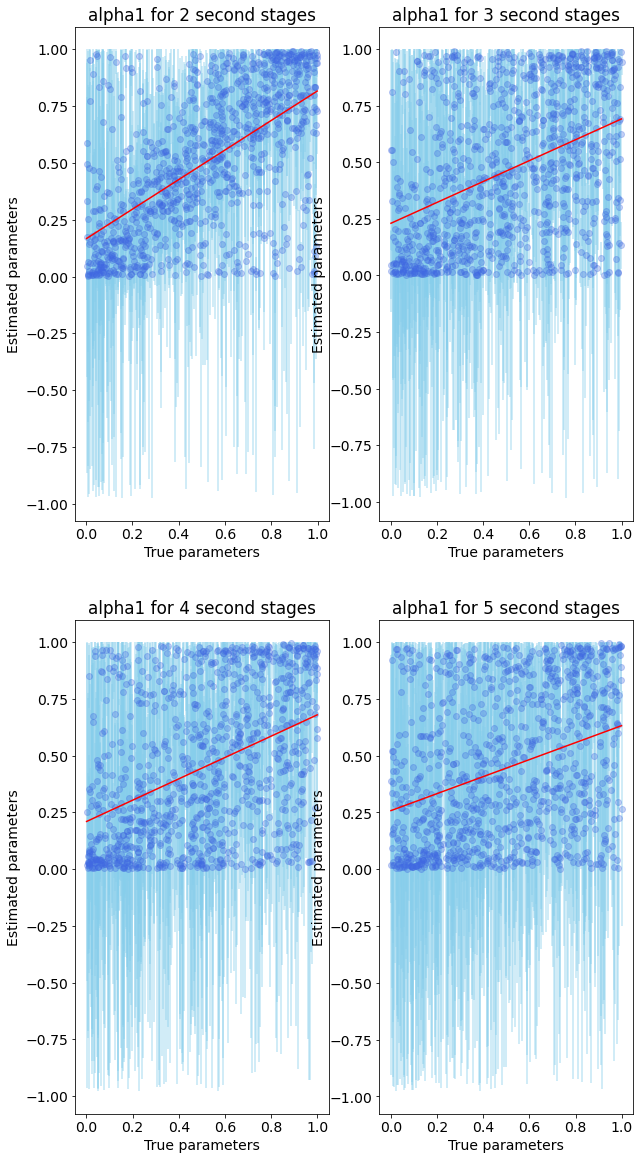

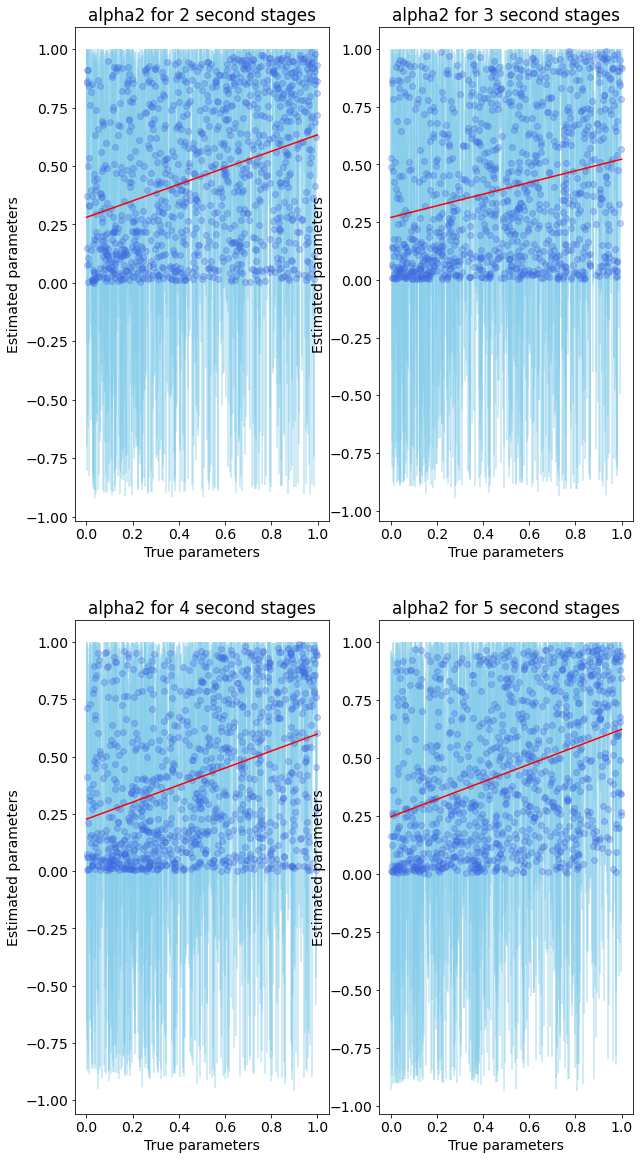

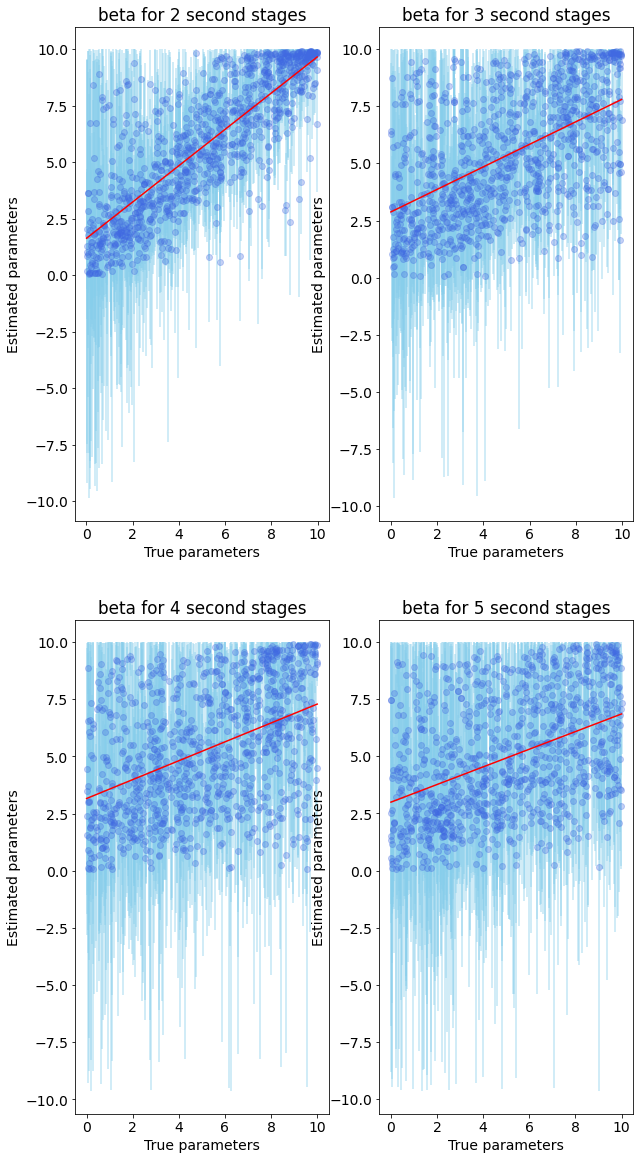

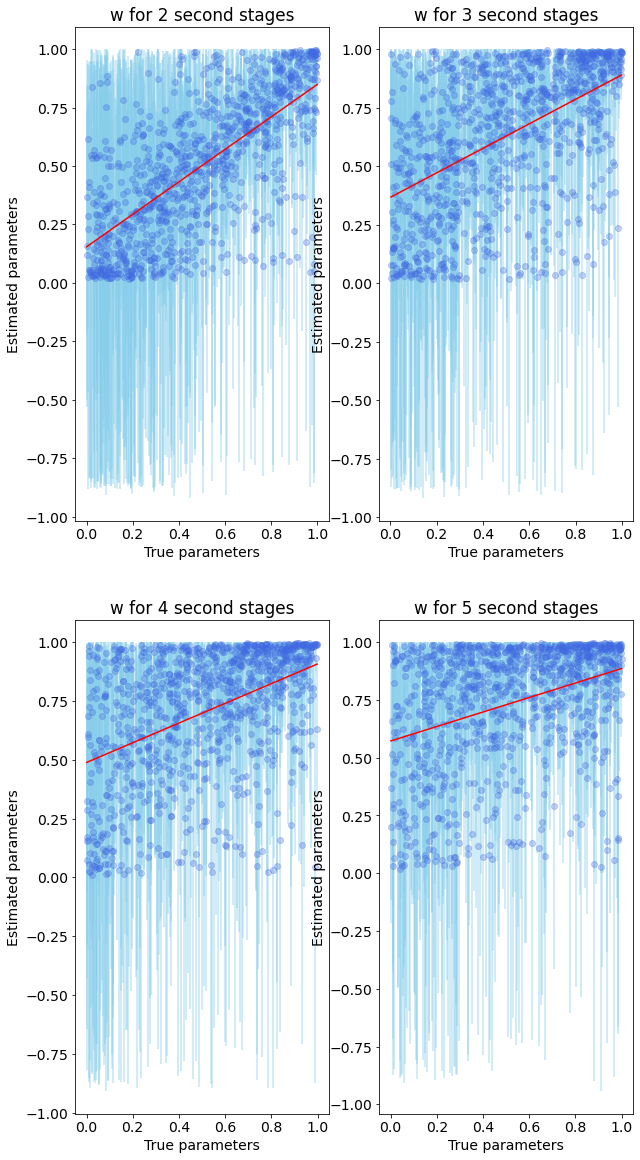

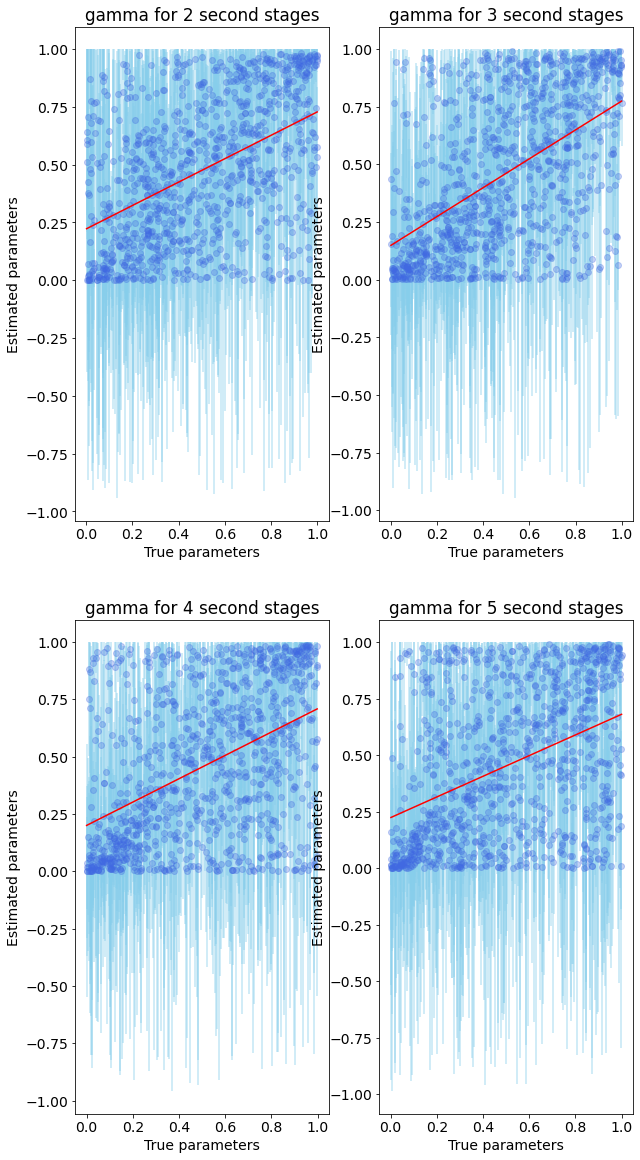

In [3]:
second_stages = [2,3,4,5]
parameters = ['alpha1', 'alpha2', 'beta', 'w', 'gamma']

for i, parameter in enumerate(parameters):
    fig, axs = plt.subplots(2,2, figsize=(10,20), facecolor='w', edgecolor='k')
#     for second_stage in second_stages:
    for s, ax in zip(range(len(second_stages)), axs.flat):
        file = 'recovery_counterfactual_diff_lr_' + str(second_stages[s]) + 'states_4params_nrits1000.mat'
#         file = 'recovery_results_' + str(second_stages[s]) + 'states_4params_nrits1000.mat'

        curr_file = io.loadmat(file)
        CI_table = curr_file['data']['CI_table']
        CI_table = np.asarray(CI_table)[0][0]
        corrtable = curr_file['data']['corrtable']
        corrtable = np.asarray(corrtable)[0][0]

        num_data = len(corrtable)

        x = corrtable[:num_data,i*2]
        y = corrtable[:num_data,i*2+1]
        ci_upper = CI_table[:num_data,i*2]
        ci_lower = CI_table[:num_data,i*2+1]

        slope, intercept = np.polyfit(x,y,1) # linear model adjustment
        y_model = np.polyval([slope, intercept], x)   # modeling...

        x_mean = np.mean(x)
        y_mean = np.mean(y)
        n = x.size                        # number of samples

        # calculating the r2
        # https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
        # Pearson's correlation coefficient
        numerator = np.sum((x - x_mean)*(y - y_mean))
        denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
        correlation_coef = numerator / denominator
        r2 = correlation_coef**2

        # mean squared error
        MSE = 1/n * np.sum( (y - y_model)**2 )

        # to plot the adjusted model
        x_line = np.linspace(np.min(x), np.max(x), 100)
        y_line = np.polyval([slope, intercept], x_line)

        ############### Ploting
        plt.rcParams.update({'font.size': 14})
#         fig = plt.figure()
#         ax = fig.add_axes([.1, .1, 1, 1])

        
    
    
        title_name = parameter + ' for ' + str(second_stages[s]) + ' second stages'
        ax.set_title(title_name)
        ax.plot(x, y, 'o', color = 'royalblue', alpha=0.3)
        ax.plot(x_line, y_line, color = 'red')
        # ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% prediction interval')
        # ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% confidence interval')

        # ax.errorbar(x,y,yerr=[y-ci_lower, ci_upper-y],linestyle='',color='skyblue', alpha=.3)
        ax.errorbar(x,y,yerr=ci_upper-y,linestyle='',color='skyblue', alpha=.5)

        ax.set_xlabel('True parameters')
        ax.set_ylabel('Estimated parameters')
        
        print("The correlation coefficient for {} {} stages: {}".format(parameter, second_stages[s], np.round(r2,2)))


# plt.subplots_adjust(wspace=1, hspace=2)

# 3. 1 alpha and more trials

The correlation coefficient for alpha 2 stages: 0.4
The correlation coefficient for alpha 3 stages: 0.25
The correlation coefficient for alpha 4 stages: 0.26
The correlation coefficient for alpha 5 stages: 0.22
The correlation coefficient for beta 2 stages: 0.65
The correlation coefficient for beta 3 stages: 0.31
The correlation coefficient for beta 4 stages: 0.2
The correlation coefficient for beta 5 stages: 0.21
The correlation coefficient for w 2 stages: 0.5
The correlation coefficient for w 3 stages: 0.4
The correlation coefficient for w 4 stages: 0.37
The correlation coefficient for w 5 stages: 0.29
The correlation coefficient for gamma 2 stages: 0.22
The correlation coefficient for gamma 3 stages: 0.4
The correlation coefficient for gamma 4 stages: 0.44
The correlation coefficient for gamma 5 stages: 0.43


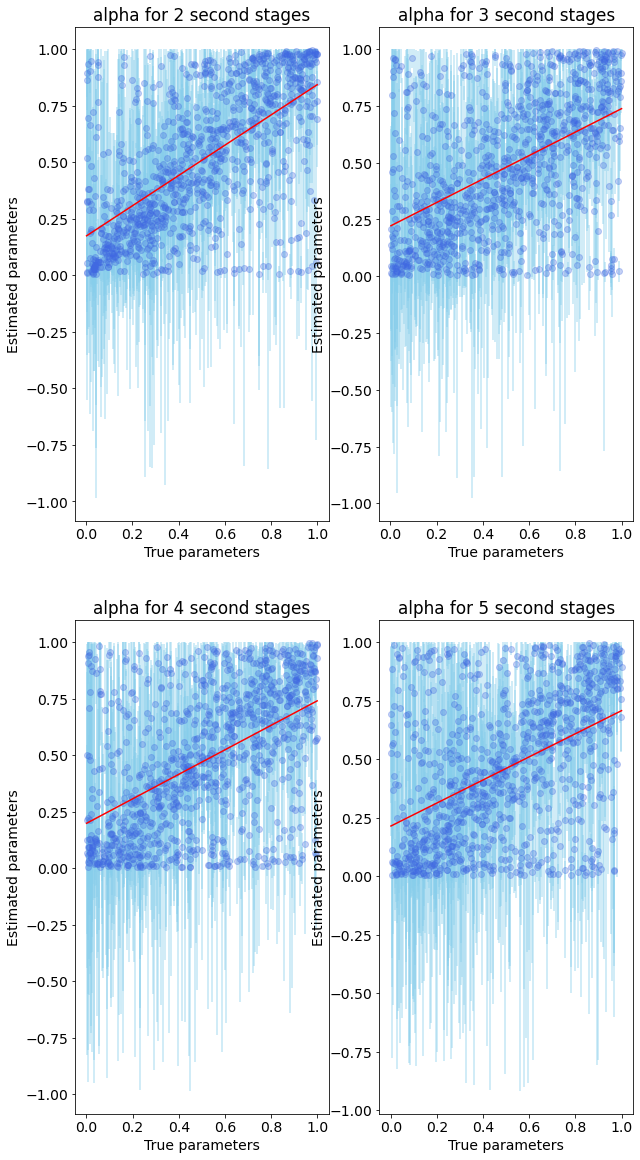

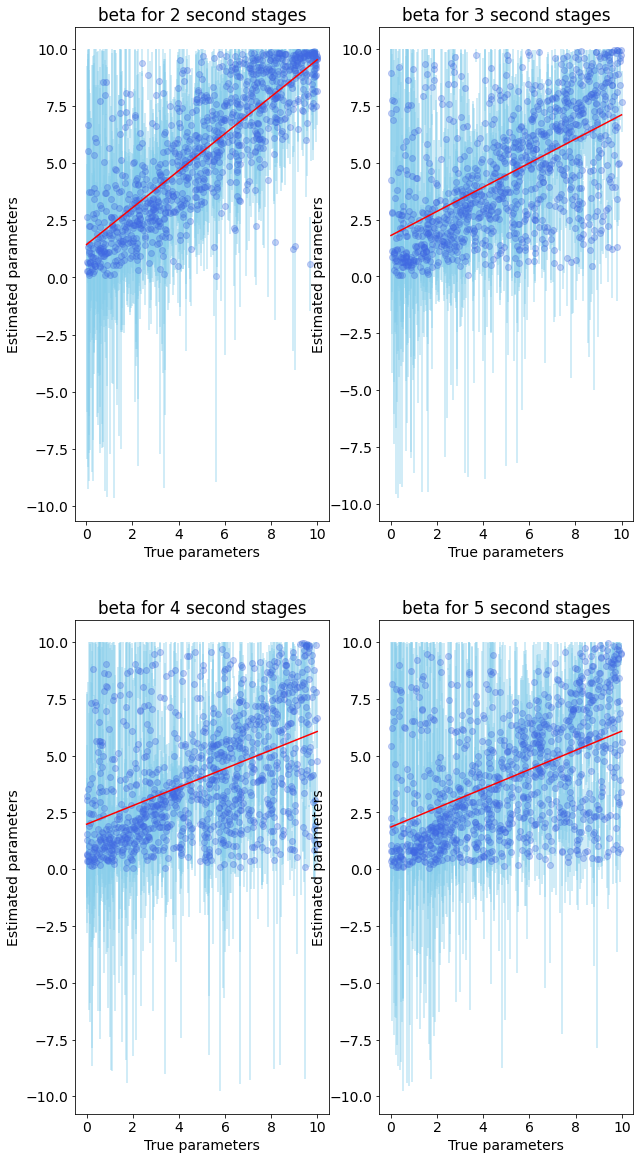

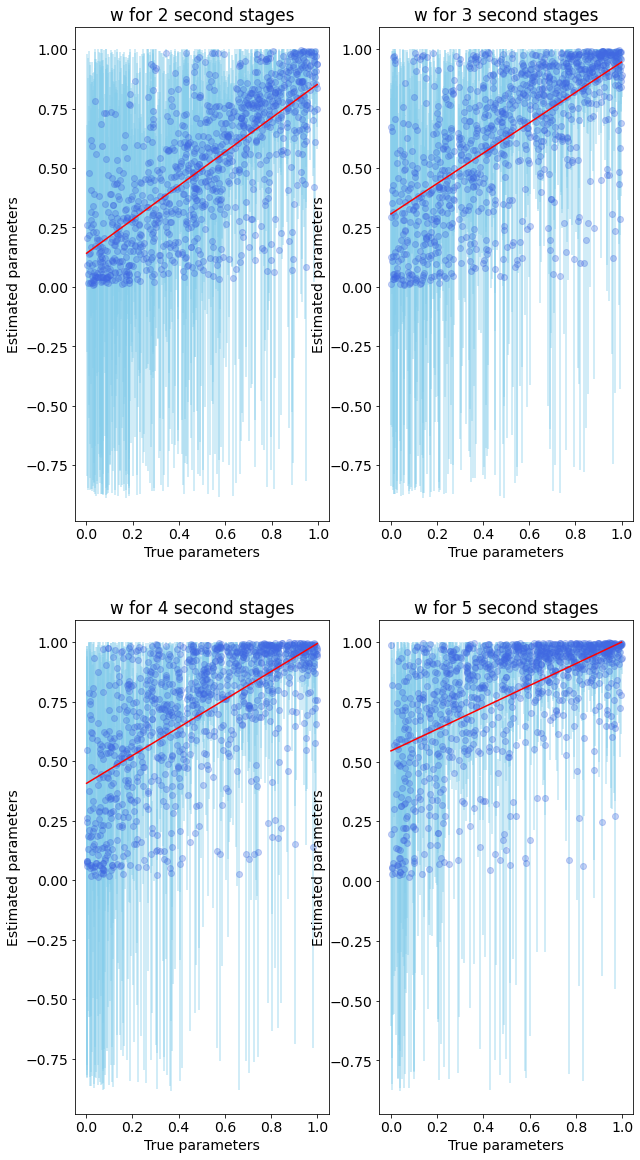

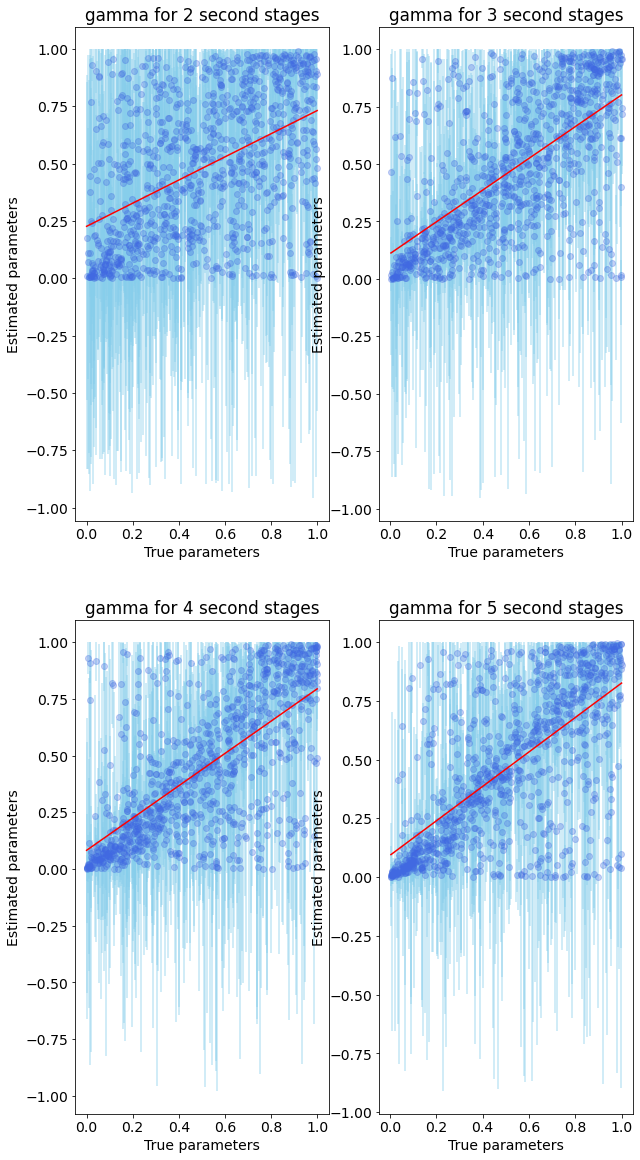

In [4]:
second_stages = [2,3,4,5]
parameters = ['alpha', 'beta', 'w', 'gamma']

for i, parameter in enumerate(parameters):
    fig, axs = plt.subplots(2,2, figsize=(10,20), facecolor='w', edgecolor='k')
#     for second_stage in second_stages:
    for s, ax in zip(range(len(second_stages)), axs.flat):
        file = 'recovery_counterfactual_1alpha_moretrials_' + str(second_stages[s]) + 'states_4params_nrits1000.mat'
#         file = 'recovery_results_' + str(second_stages[s]) + 'states_4params_nrits1000.mat'

        curr_file = io.loadmat(file)
        CI_table = curr_file['data']['CI_table']
        CI_table = np.asarray(CI_table)[0][0]
        corrtable = curr_file['data']['corrtable']
        corrtable = np.asarray(corrtable)[0][0]

        num_data = len(corrtable)

        x = corrtable[:num_data,i*2]
        y = corrtable[:num_data,i*2+1]
        ci_upper = CI_table[:num_data,i*2]
        ci_lower = CI_table[:num_data,i*2+1]

        slope, intercept = np.polyfit(x,y,1) # linear model adjustment
        y_model = np.polyval([slope, intercept], x)   # modeling...

        x_mean = np.mean(x)
        y_mean = np.mean(y)
        n = x.size                        # number of samples

        # calculating the r2
        # https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
        # Pearson's correlation coefficient
        numerator = np.sum((x - x_mean)*(y - y_mean))
        denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
        correlation_coef = numerator / denominator
        r2 = correlation_coef**2

        # mean squared error
        MSE = 1/n * np.sum( (y - y_model)**2 )

        # to plot the adjusted model
        x_line = np.linspace(np.min(x), np.max(x), 100)
        y_line = np.polyval([slope, intercept], x_line)

        ############### Ploting
        plt.rcParams.update({'font.size': 14})
#         fig = plt.figure()
#         ax = fig.add_axes([.1, .1, 1, 1])

        
    
    
        title_name = parameter + ' for ' + str(second_stages[s]) + ' second stages'
        ax.set_title(title_name)
        ax.plot(x, y, 'o', color = 'royalblue', alpha=0.3)
        ax.plot(x_line, y_line, color = 'red')
        # ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% prediction interval')
        # ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% confidence interval')

        # ax.errorbar(x,y,yerr=[y-ci_lower, ci_upper-y],linestyle='',color='skyblue', alpha=.3)
        ax.errorbar(x,y,yerr=ci_upper-y,linestyle='',color='skyblue', alpha=.5)

        ax.set_xlabel('True parameters')
        ax.set_ylabel('Estimated parameters')
        
        print("The correlation coefficient for {} {} stages: {}".format(parameter, second_stages[s], np.round(r2,2)))


# plt.subplots_adjust(wspace=1, hspace=2)

# 4. 2 alphas and more trials

The correlation coefficient for alpha1 2 stages: 0.41
The correlation coefficient for alpha1 3 stages: 0.33
The correlation coefficient for alpha1 4 stages: 0.31
The correlation coefficient for alpha1 5 stages: 0.28
The correlation coefficient for alpha2beta 2 stages: 0.13
The correlation coefficient for alpha2beta 3 stages: 0.19


/opt/anaconda3/envs/simulation/lib/python3.9/site-packages/numpy/ma/core.py:3380: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/opt/anaconda3/envs/simulation/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/simulation/lib/python3.9/site-packages/numpy/ma/core.py:3380: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/opt/anaconda3/envs/simulation/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


The correlation coefficient for alpha2beta 4 stages: 0.19
The correlation coefficient for alpha2beta 5 stages: 0.23
The correlation coefficient for w 2 stages: 0.66
The correlation coefficient for w 3 stages: 0.39


/opt/anaconda3/envs/simulation/lib/python3.9/site-packages/numpy/ma/core.py:3380: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/opt/anaconda3/envs/simulation/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/simulation/lib/python3.9/site-packages/numpy/ma/core.py:3380: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/opt/anaconda3/envs/simulation/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


The correlation coefficient for w 4 stages: 0.39
The correlation coefficient for w 5 stages: 0.31
The correlation coefficient for gamma 2 stages: 0.52
The correlation coefficient for gamma 3 stages: 0.4
The correlation coefficient for gamma 4 stages: 0.25
The correlation coefficient for gamma 5 stages: 0.21


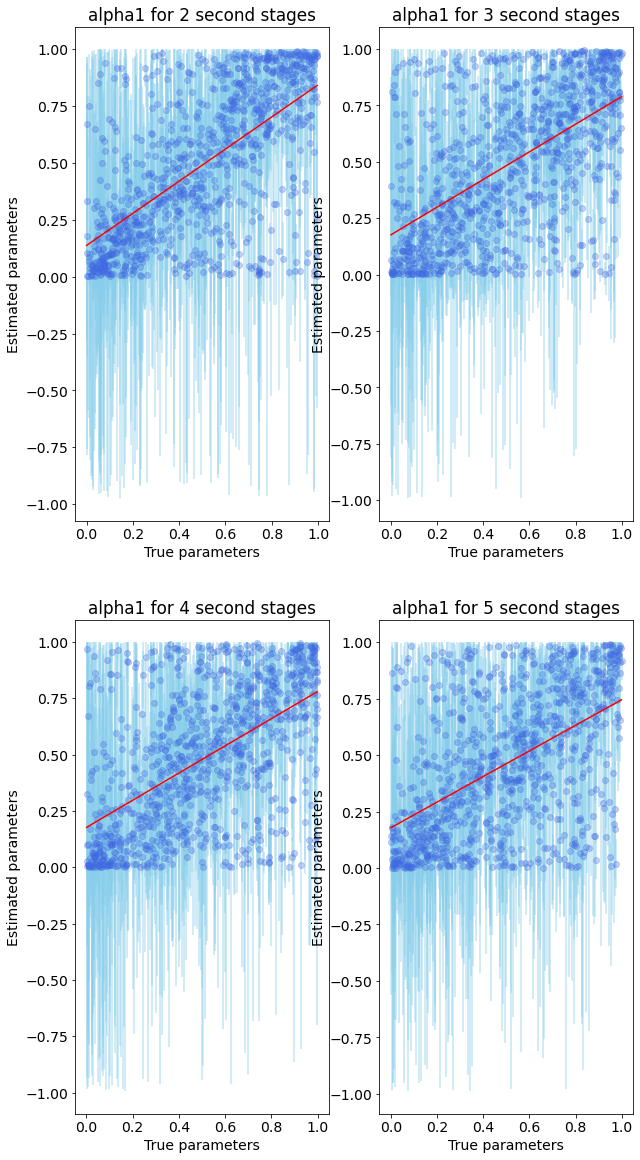

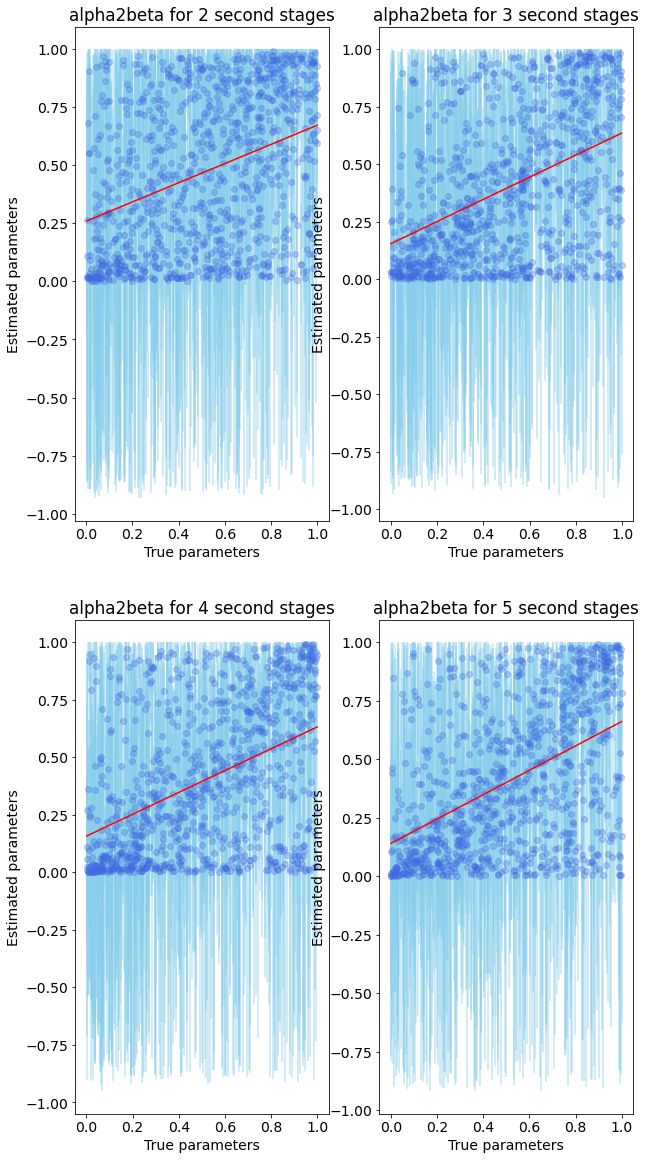

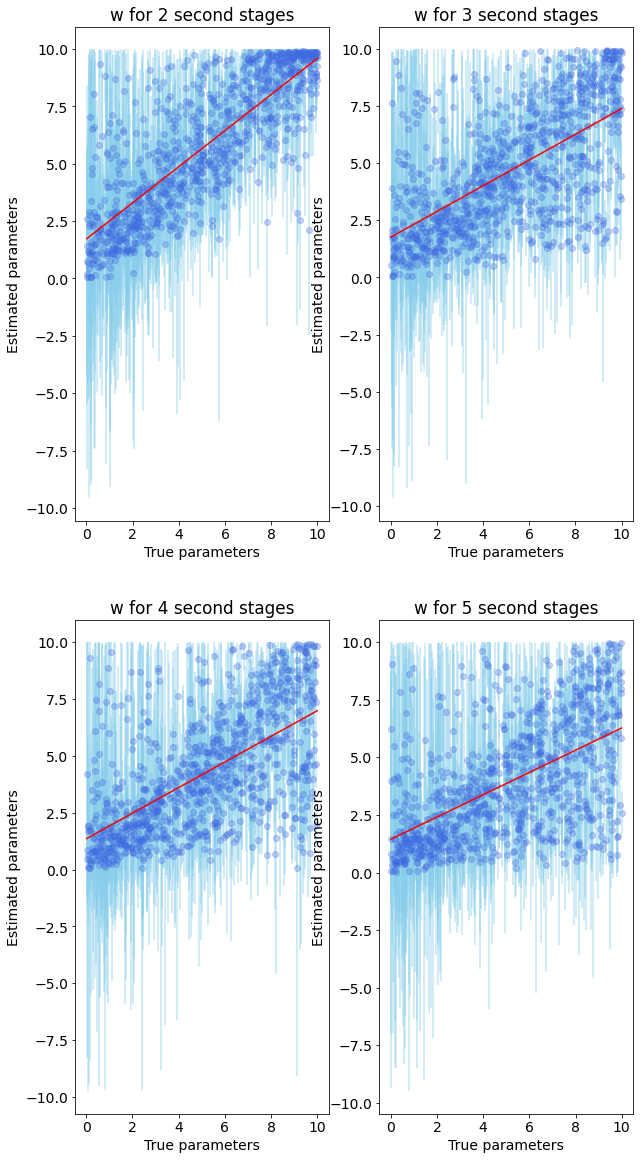

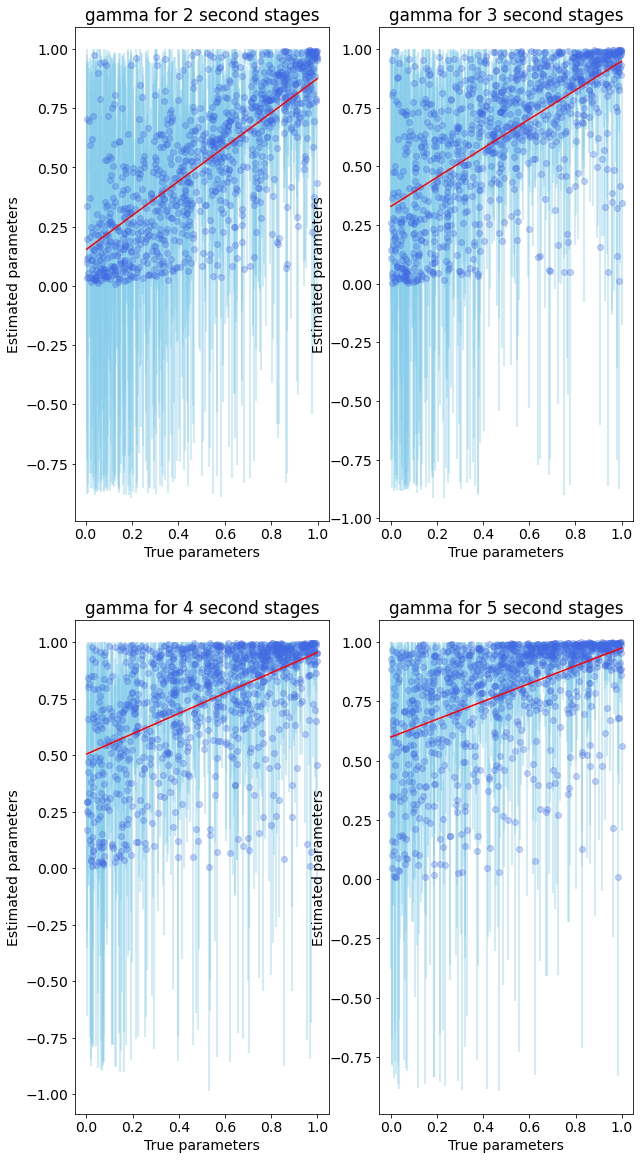

In [6]:
second_stages = [2,3,4,5]
parameters = ['alpha1', 'alpha2' 'beta', 'w', 'gamma']

for i, parameter in enumerate(parameters):
    fig, axs = plt.subplots(2,2, figsize=(10,20), facecolor='w', edgecolor='k')
#     for second_stage in second_stages:
    for s, ax in zip(range(len(second_stages)), axs.flat):
        file = 'recovery_counterfactual_diff_lr_moretrials_' + str(second_stages[s]) + 'states_4params_nrits1000.mat'
#         file = 'recovery_results_' + str(second_stages[s]) + 'states_4params_nrits1000.mat'

        curr_file = io.loadmat(file)
        CI_table = curr_file['data']['CI_table']
        CI_table = np.asarray(CI_table)[0][0]
        corrtable = curr_file['data']['corrtable']
        corrtable = np.asarray(corrtable)[0][0]

        num_data = len(corrtable)

        x = corrtable[:num_data,i*2]
        y = corrtable[:num_data,i*2+1]
        ci_upper = CI_table[:num_data,i*2]
        ci_lower = CI_table[:num_data,i*2+1]

        slope, intercept = np.polyfit(x,y,1) # linear model adjustment
        y_model = np.polyval([slope, intercept], x)   # modeling...

        x_mean = np.mean(x)
        y_mean = np.mean(y)
        n = x.size                        # number of samples

        # calculating the r2
        # https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
        # Pearson's correlation coefficient
        numerator = np.sum((x - x_mean)*(y - y_mean))
        denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
        correlation_coef = numerator / denominator
        r2 = correlation_coef**2

        # mean squared error
        MSE = 1/n * np.sum( (y - y_model)**2 )

        # to plot the adjusted model
        x_line = np.linspace(np.min(x), np.max(x), 100)
        y_line = np.polyval([slope, intercept], x_line)

        ############### Ploting
        plt.rcParams.update({'font.size': 14})
#         fig = plt.figure()
#         ax = fig.add_axes([.1, .1, 1, 1])

        
    
    
        title_name = parameter + ' for ' + str(second_stages[s]) + ' second stages'
        ax.set_title(title_name)
        ax.plot(x, y, 'o', color = 'royalblue', alpha=0.3)
        ax.plot(x_line, y_line, color = 'red')
        # ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% prediction interval')
        # ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% confidence interval')

        # ax.errorbar(x,y,yerr=[y-ci_lower, ci_upper-y],linestyle='',color='skyblue', alpha=.3)
        ax.errorbar(x,y,yerr=ci_upper-y,linestyle='',color='skyblue', alpha=.5)

        ax.set_xlabel('True parameters')
        ax.set_ylabel('Estimated parameters')
        
        print("The correlation coefficient for {} {} stages: {}".format(parameter, second_stages[s], np.round(r2,2)))


# plt.subplots_adjust(wspace=1, hspace=2)